In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.stattools as st
from statsmodels.tsa.arima_model import ARMA
from scipy import stats
from pandas import to_datetime

#Balance=pd.read_excel("C:/FDDC_financial_data/FDDC_financial_data/Financial Data/Balance Sheet.xls",sheetname="General Business")
#print (Balance.shape)
#for col in Balance.columns:
#    if len(Balance[Balance[col].isna()==True])/Balance.shape[0]>0.5:
#        Balance=Balance.drop(col, axis=1)

def addZero(symbol):#该函数负责将股票代码前面的0补全
    if(len(symbol)==1):
        return "00000"+symbol
    if(len(symbol)==2):
        return "0000"+symbol
    if(len(symbol)==3):
        return "000"+symbol
    if(len(symbol)==4):
        return "00"+symbol
    if(len(symbol)==5):
        return "0"+symbol
    if(len(symbol)==6):
        return symbol
def plotsymbol(symbol,x,y):#画出代码为symbol的股票的图，x可以为日期，y可以为营收，利润等
    plt.plot(Income.loc[Income['TICKER_SYMBOL']==symbol][x],Income.loc[Income['TICKER_SYMBOL']==symbol][y])

Income=pd.read_excel("C:/FDDC_financial_data/FDDC_financial_data/Financial Data/Income Statement.xls",sheet_name="General Business")

In [39]:
print ("处理前的数据有%d行，%d列"%(Income.shape[0],Income.shape[1]))

处理前的数据有208133行，68列


In [40]:
#去除唯一值，去除多余的日期选项，只保留一个END_DATE
Income=Income.drop(['PARTY_ID','EXCHANGE_CD','PUBLISH_DATE','END_DATE_REP','FISCAL_PERIOD','MERGED_FLAG'],axis=1)
#去除T_REVENUE,与Revenue高度相关,去除DILUTED_EPS，与basic_eps高度相关
Income=Income.drop(['T_REVENUE','DILUTED_EPS'],axis=1)

In [41]:
#去除空值占比超过50%的值
for col in Income.columns:
    if Income[col].isnull().sum()/Income.shape[0]>0.5:
        Income=Income.drop(col, axis=1)
        print("列%s已经被去除"%col)

列INT_INCOME已经被去除
列PREM_EARNED已经被去除
列COMMIS_INCOME已经被去除
列SPEC_TOR已经被去除
列ATOR已经被去除
列INT_EXP已经被去除
列COMMIS_EXP已经被去除
列PREM_REFUND已经被去除
列N_COMPENS_PAYOUT已经被去除
列RESER_INSUR_CONTR已经被去除
列POLICY_DIV_PAYT已经被去除
列REINSUR_EXP已经被去除
列SPEC_TOC已经被去除
列ATOC已经被去除
列F_VALUE_CHG_GAIN已经被去除
列A_J_INVEST_INCOME已经被去除
列FOREX_GAIN已经被去除
列OTH_EFFECT_OP已经被去除
列ASSETS_DISP_GAIN已经被去除
列AE_EFFECT_OP已经被去除
列OTH_GAIN已经被去除
列OTH_EFFECT_TP已经被去除
列AE_EFFECT_TP已经被去除
列OTH_EFFECT_NP已经被去除
列AE_EFFECT_NP已经被去除
列GOING_CONCERN_NI已经被去除
列QUIT_CONCERN_NI已经被去除
列N_INCOME_BMA已经被去除
列OTH_EFFECT_NPP已经被去除
列AE_EFFECT_NPP已经被去除
列OTH_COMPR_INCOME已经被去除
列OTH_EFFECT_CI已经被去除
列AE_EFFECT_CI已经被去除
列OTH_EFFECT_PCI已经被去除
列AE_EFFECT_PCI已经被去除


In [42]:
Income.duplicated().sum()

54018

In [43]:
#将股票代码变为字符串型
Income['TICKER_SYMBOL']=Income['TICKER_SYMBOL'].astype(str)
#股票代码加0
Income['TICKER_SYMBOL']=Income['TICKER_SYMBOL'].apply(addZero)
#将END_DATE转变为日期类型
Income['END_DATE']=pd.to_datetime(Income['END_DATE'],format='%Y-%m-%d')
#将重复的行删除
Income=Income.drop_duplicates()
#按照股票代码，日期分组
Income=Income.sort_values(['TICKER_SYMBOL','END_DATE'])
print ("处理后的数据有%d行，%d列"%(Income.shape[0],Income.shape[1]))

处理后的数据有154115行，25列


In [44]:
Income.duplicated().sum()

0

In [45]:
Income[['TICKER_SYMBOL','END_DATE']].duplicated().sum()

43263

In [46]:
#观察重复值的样本，可以发现第二次重复的值有了新的值，可能是报告期补充了新的数据，
Income[(Income['TICKER_SYMBOL']=='000002')&(Income['END_DATE']=='2009-03-31')]

,TICKER_SYMBOL,END_DATE,REPORT_TYPE,REVENUE,T_COGS,COGS,BIZ_TAX_SURCHG,SELL_EXP,ADMIN_EXP,FINAN_EXP,...,NCA_DISPLOSS,T_PROFIT,INCOME_TAX,N_INCOME,N_INCOME_ATTR_P,MINORITY_GAIN,BASIC_EPS,T_COMPR_INCOME,COMPR_INC_ATTR_P,COMPR_INC_ATTR_M_S
940,000002,2009-03-31,Q1,8.164319e+09,6.966013e+09,5.404079e+09,855571912.3,2.385783e+08,2.828142e+08,1.843188e+08,...,115925.68,1.227682e+09,3.391397e+08,8.885426e+08,7.687640e+08,1.197785e+08,0.07,NaN,NaN,NaN
1106,000002,2009-03-31,Q1,8.164319e+09,6.966013e+09,5.404079e+09,855571912.3,2.385783e+08,2.828142e+08,1.843188e+08,...,115925.68,1.227682e+09,3.391397e+08,8.885426e+08,7.687640e+08,1.197785e+08,0.07,9.188037e+08,7.990252e+08,1.197785e+08


In [47]:
Income=Income.drop_duplicates(['TICKER_SYMBOL','END_DATE'],keep='last')
print ("处理后的数据有%d行，%d列"%(Income.shape[0],Income.shape[1]))

处理后的数据有110852行，25列


In [48]:
#观察同一只股票的同一期，是否还有重复值
Income[['TICKER_SYMBOL','END_DATE']].duplicated().sum()

0

In [49]:
Income[(Income['TICKER_SYMBOL']=='000002')&(Income['END_DATE']=='2009-03-31')]

,TICKER_SYMBOL,END_DATE,REPORT_TYPE,REVENUE,T_COGS,COGS,BIZ_TAX_SURCHG,SELL_EXP,ADMIN_EXP,FINAN_EXP,...,NCA_DISPLOSS,T_PROFIT,INCOME_TAX,N_INCOME,N_INCOME_ATTR_P,MINORITY_GAIN,BASIC_EPS,T_COMPR_INCOME,COMPR_INC_ATTR_P,COMPR_INC_ATTR_M_S
1106,000002,2009-03-31,Q1,8.164319e+09,6.966013e+09,5.404079e+09,855571912.3,2.385783e+08,2.828142e+08,1.843188e+08,...,115925.68,1.227682e+09,3.391397e+08,8.885426e+08,7.687640e+08,1.197785e+08,0.07,9.188037e+08,7.990252e+08,1.197785e+08


In [50]:
#观察处理后各个列空值的比例
for col in Income.columns:
    print ("列%s共有百分之%.5f的值是空值"%(col,100*Income[col].isnull().sum()/Income.shape[0]))

列TICKER_SYMBOL共有百分之0.00000的值是空值
列END_DATE共有百分之0.00000的值是空值
列REPORT_TYPE共有百分之0.00000的值是空值
列REVENUE共有百分之0.00812的值是空值
列T_COGS共有百分之0.00000的值是空值
列COGS共有百分之0.15336的值是空值
列BIZ_TAX_SURCHG共有百分之0.97517的值是空值
列SELL_EXP共有百分之2.97514的值是空值
列ADMIN_EXP共有百分之0.01173的值是空值
列FINAN_EXP共有百分之0.03789的值是空值
列ASSETS_IMPAIR_LOSS共有百分之9.27182的值是空值
列INVEST_INCOME共有百分之27.18580的值是空值
列OPERATE_PROFIT共有百分之0.00000的值是空值
列NOPERATE_INCOME共有百分之1.79248的值是空值
列NOPERATE_EXP共有百分之4.56104的值是空值
列NCA_DISPLOSS共有百分之45.41190的值是空值
列T_PROFIT共有百分之0.00000的值是空值
列INCOME_TAX共有百分之3.48663的值是空值
列N_INCOME共有百分之0.00000的值是空值
列N_INCOME_ATTR_P共有百分之0.00000的值是空值
列MINORITY_GAIN共有百分之22.99102的值是空值
列BASIC_EPS共有百分之1.25392的值是空值
列T_COMPR_INCOME共有百分之6.98770的值是空值
列COMPR_INC_ATTR_P共有百分之7.07249的值是空值
列COMPR_INC_ATTR_M_S共有百分之29.87497的值是空值


In [51]:
Revenue_na=[]
#检测营收是否有首期为空的，如果有，将用线性替代
for symbol in Income['TICKER_SYMBOL'].unique():
    if Income.loc[Income['TICKER_SYMBOL']==symbol]['REVENUE'].isnull().sum()>0:
        Revenue_na.append(symbol)
print (Revenue_na)

['600145', '600149', '600421', '600738', '900957']


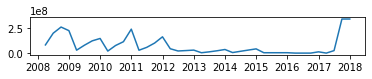

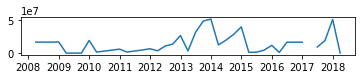

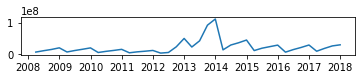

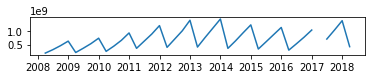

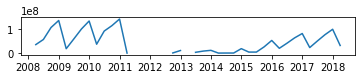

In [52]:
#在处理前，包含营收缺失值的股票代码的缺失情况
j=1
for symbol in Revenue_na:
    temp=Income[Income['TICKER_SYMBOL']==symbol]['REVENUE'].copy()
    temp=temp.interpolate()
    plt.subplot(5,1,j)
    plt.plot(Income.loc[Income['TICKER_SYMBOL']==symbol]['END_DATE'],Income.loc[Income['TICKER_SYMBOL']==symbol]['REVENUE'])
    j=j+1
    plt.show()
    for idx in temp.index:
        Income.loc[idx,'REVENUE']=temp.loc[idx,]

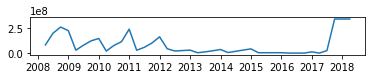

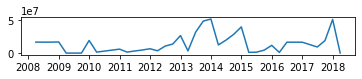

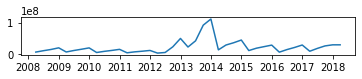

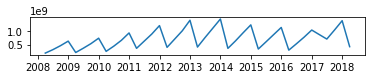

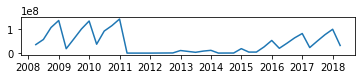

In [53]:
#在处理后，包含营收缺失值的股票代码的缺失情况
j=1
for symbol in Revenue_na:
    plt.subplot(5,1,j)
    plt.plot(Income.loc[Income['TICKER_SYMBOL']==symbol]['END_DATE'],Income.loc[Income['TICKER_SYMBOL']==symbol]['REVENUE'])
    j=j+1
    plt.show()

In [54]:
#继续查找其它包含缺失值的列
cols_contains_na=[]
for col in Income.columns:
    if Income[col].isnull().sum()>0:
        cols_contains_na.append(col)
print(cols_contains_na)

['COGS', 'BIZ_TAX_SURCHG', 'SELL_EXP', 'ADMIN_EXP', 'FINAN_EXP', 'ASSETS_IMPAIR_LOSS', 'INVEST_INCOME', 'NOPERATE_INCOME', 'NOPERATE_EXP', 'NCA_DISPLOSS', 'INCOME_TAX', 'MINORITY_GAIN', 'BASIC_EPS', 'T_COMPR_INCOME', 'COMPR_INC_ATTR_P', 'COMPR_INC_ATTR_M_S']


In [55]:
#将其余列缺失值用均值填充
for col in cols_contains_na:
    Income[col]=Income[col].fillna(Income[col].mean())

In [56]:
#最终查找包含空值的列
cols_contains_na=[]
for col in Income.columns:
    if Income[col].isnull().sum()>0:
        cols_contains_na.append(col)
print(cols_contains_na)

[]


In [57]:
Income.dtypes

TICKER_SYMBOL                 object
END_DATE              datetime64[ns]
REPORT_TYPE                   object
REVENUE                      float64
T_COGS                       float64
COGS                         float64
BIZ_TAX_SURCHG               float64
SELL_EXP                     float64
ADMIN_EXP                    float64
FINAN_EXP                    float64
ASSETS_IMPAIR_LOSS           float64
INVEST_INCOME                float64
OPERATE_PROFIT               float64
NOPERATE_INCOME              float64
NOPERATE_EXP                 float64
NCA_DISPLOSS                 float64
T_PROFIT                     float64
INCOME_TAX                   float64
N_INCOME                     float64
N_INCOME_ATTR_P              float64
MINORITY_GAIN                float64
BASIC_EPS                    float64
T_COMPR_INCOME               float64
COMPR_INC_ATTR_P             float64
COMPR_INC_ATTR_M_S           float64
dtype: object

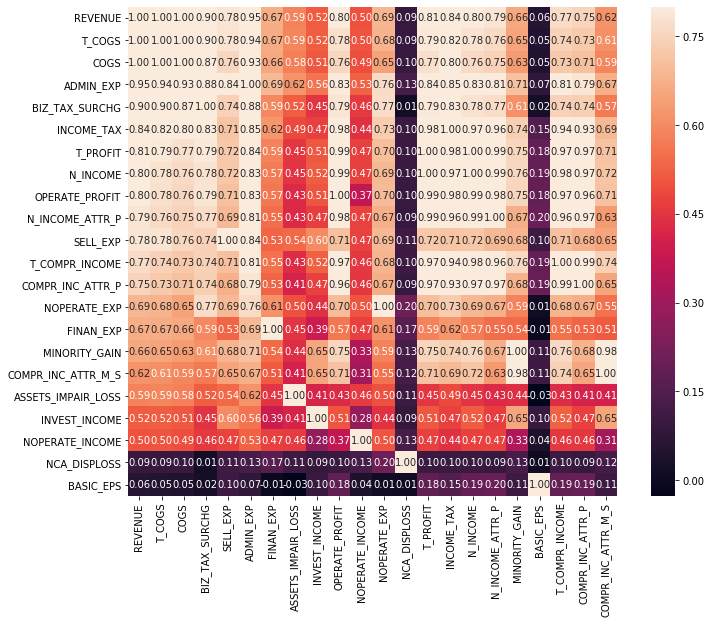

In [58]:
corrmat=Income.loc[:,'REVENUE':].corr().sort_values(by='REVENUE',ascending=False)
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,annot=True, vmax=.8, fmt='.2f',square=True);

In [59]:
#改变为日期类型index
Income.index=Income['END_DATE']
Income=Income.drop('END_DATE',axis=1)
Income.head()

,TICKER_SYMBOL,REPORT_TYPE,REVENUE,T_COGS,COGS,BIZ_TAX_SURCHG,SELL_EXP,ADMIN_EXP,FINAN_EXP,ASSETS_IMPAIR_LOSS,...,NCA_DISPLOSS,T_PROFIT,INCOME_TAX,N_INCOME,N_INCOME_ATTR_P,MINORITY_GAIN,BASIC_EPS,T_COMPR_INCOME,COMPR_INC_ATTR_P,COMPR_INC_ATTR_M_S
END_DATE,,,,,,,,,,,,,,,,,,,,,
2008-03-31,000002,Q1,6.400436e+09,5.363943e+09,3.925913e+09,6.476807e+08,2.784145e+08,3.716066e+08,1.330892e+08,7.239781e+06,...,3.186763e+06,1.022828e+09,2.810980e+08,7.417298e+08,7.181333e+08,2.359653e+07,0.065,2.645500e+08,2.353865e+08,3.859405e+07
2008-06-30,000002,S1,1.725501e+10,1.394702e+10,1.017141e+10,2.039138e+09,7.091833e+08,8.167439e+08,2.007706e+08,9.768106e+06,...,3.258875e+05,3.327956e+09,1.021286e+09,2.306670e+09,2.061056e+09,2.456144e+08,0.187,2.372688e+09,2.127073e+09,2.456144e+08
2008-09-30,000002,Q3,2.254191e+10,1.887138e+10,1.341616e+10,2.480042e+09,1.133777e+09,1.003706e+09,2.728555e+08,5.648361e+08,...,9.458111e+05,3.750421e+09,1.116101e+09,2.634320e+09,2.276542e+09,3.577786e+08,0.207,2.686515e+09,2.328737e+09,3.577786e+08
2008-12-31,000002,A,4.099178e+10,3.485566e+10,2.500527e+10,4.533873e+09,1.860350e+09,1.530799e+09,6.572533e+08,1.268113e+09,...,2.336423e+06,6.322286e+09,1.682416e+09,4.639869e+09,4.033170e+09,6.066991e+08,0.370,4.679224e+09,4.072524e+09,6.066991e+08
2009-03-31,000002,Q1,8.164319e+09,6.966013e+09,5.404079e+09,8.555719e+08,2.385783e+08,2.828142e+08,1.843188e+08,6.516473e+05,...,1.159257e+05,1.227682e+09,3.391397e+08,8.885426e+08,7.687640e+08,1.197785e+08,0.070,9.188037e+08,7.990252e+08,1.197785e+08


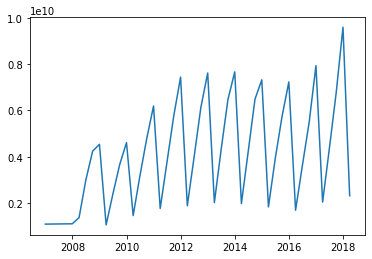

In [60]:
plt.plot(Income['REVENUE'].groupby(Income.index).mean())

In [61]:
Income['REVENUE'].groupby(Income.index).mean()

END_DATE
2006-12-31    1.089345e+09
2007-12-31    1.103474e+09
2008-03-31    1.370690e+09
2008-06-30    2.988765e+09
2008-09-30    4.239238e+09
2008-12-31    4.531976e+09
2009-03-31    1.055029e+09
2009-06-30    2.382955e+09
2009-09-30    3.658178e+09
2009-12-31    4.607559e+09
2010-03-31    1.458617e+09
2010-06-30    3.168300e+09
2010-09-30    4.779557e+09
2010-12-31    6.187836e+09
2011-03-31    1.764677e+09
2011-06-30    3.754361e+09
2011-09-30    5.763125e+09
2011-12-31    7.433825e+09
2012-03-31    1.881942e+09
2012-06-30    3.975397e+09
2012-09-30    6.129352e+09
2012-12-31    7.612796e+09
2013-03-31    2.020071e+09
2013-06-30    4.296674e+09
2013-09-30    6.463422e+09
2013-12-31    7.660120e+09
2014-03-31    1.977804e+09
2014-06-30    4.202299e+09
2014-09-30    6.479314e+09
2014-12-31    7.316931e+09
2015-03-31    1.831155e+09
2015-06-30    3.907263e+09
2015-09-30    5.728017e+09
2015-12-31    7.225140e+09
2016-03-31    1.689730e+09
2016-06-30    3.598536e+09
2016-09-30    5.475

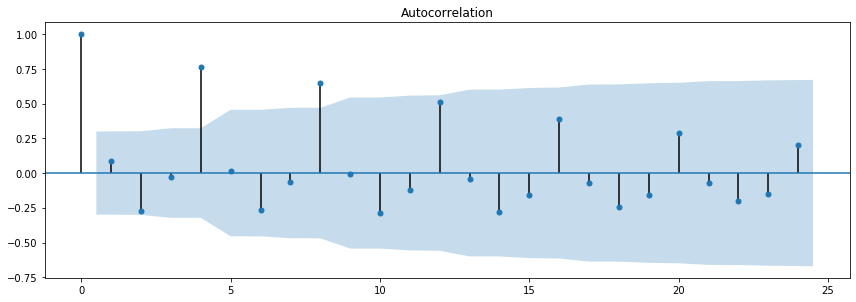

In [62]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(Income['REVENUE'].groupby(Income.index).mean(), lags=24,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

In [63]:
model = ARMA(Income['REVENUE'].groupby(Income.index).mean(),order=(12,0))
results_ARMA = model.fit(disp=-1, method='mle')
results_ARMA

d:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [64]:
pred = results_ARMA.predict(start='2008-12-31', end='2018-03-31')
print(pred)


END_DATE
2008-12-31    3.341090e+09
2009-03-31    3.339375e+09
2009-06-30    1.527522e+09
2009-09-30    3.480702e+09
2009-12-31    4.565720e+09
2010-03-31    9.533862e+08
2010-06-30    4.283266e+09
2010-09-30    4.688667e+09
2010-12-31    5.869071e+09
2011-03-31    2.370864e+09
2011-06-30    2.721591e+09
2011-09-30    5.070053e+09
2011-12-31    7.119617e+09
2012-03-31    2.408366e+09
2012-06-30    3.936876e+09
2012-09-30    6.020736e+09
2012-12-31    7.996047e+09
2013-03-31    1.885816e+09
2013-06-30    4.364844e+09
2013-09-30    6.432028e+09
2013-12-31    7.882466e+09
2014-03-31    2.173870e+09
2014-06-30    4.116559e+09
2014-09-30    6.322026e+09
2014-12-31    7.696448e+09
2015-03-31    1.935975e+09
2015-06-30    4.010599e+09
2015-09-30    6.273038e+09
2015-12-31    6.645512e+09
2016-03-31    2.301877e+09
2016-06-30    3.524841e+09
2016-09-30    5.276686e+09
2016-12-31    7.326535e+09
2017-03-31    2.280368e+09
2017-06-30    3.388930e+09
2017-09-30    5.771824e+09
2017-12-31    8.944

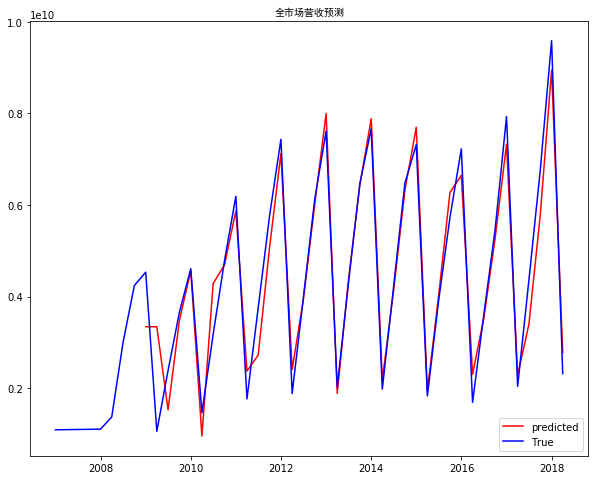

In [65]:
fig = plt.figure(figsize=(10, 8))
plt.title('全市场营收预测',fontproperties='SimHei')
plt.plot(pred,'r-',label='predicted')
plt.plot(Income['REVENUE'].groupby(Income.index).mean(),'b-',label='True')
plt.legend(loc='lower right')